In [1]:
#import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from collections import defaultdict
import pandas as pd

In [2]:
np.random.seed(7)

In [3]:
def get_triplets(lst):
    """
    '1234' -> ['123','234']
    """
    res = []
    for i in range(len(lst) - 2):
        res.append(lst[i]+lst[i + 1]+lst[i + 2])
    return res


def get_dinucleotides(lst):
    """
    '123' -> ['12', '23']
    """
    res = []
    for i in range(len(lst) - 1):
        res.append(lst[i]+lst[i + 1])
    return res

In [4]:
#True: Last bases of Alus
with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/Alu_All_50_bs_2.txt','r') as f:
    dt = np.unique(list(map(lambda x: x.strip(),f.readlines())))
# Last bases of L1    

with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/L1_last_50_bs_2.txt','r') as f:
    dt = np.append(dt, np.unique(list(map(lambda x: x.strip(),f.readlines()))))

In [5]:
#False: Random genome sequences
with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/random_nt_seq.txt','r') as f:
    df = np.unique(list(map(lambda x: x.strip(),f.readlines())))


In [6]:
len(dt), len(df)

(9265, 19999)

In [7]:
# Balancing alternative
# d = df if len(df) > len(dt) else dt
p = len(df)/len(dt); m = min(p,1/p)
np.random.seed(7)
df = np.random.choice(df,round(len(df)*m), replace=False)
dt = np.random.choice(dt, len(dt), replace=False)

In [8]:
len(dt), len(df)

(9265, 9265)

In [9]:
alph = ['A','C','G','T']
alph_dict = {'A':1,'C':2,'G':3,'T':4}
pairs = [''.join(i) for i in product(alph, repeat=2)]
triplets = [''.join(i) for i in product(alph, repeat=3)]

In [10]:
x_t, y_t = [], []
for line in dt:
    row = {}
    for di_n in get_dinucleotides(line)+get_triplets(line):
        row[di_n]=row.get(di_n,0)+1
    for pos in range(len(line)):
        row[f'P{pos}']=alph_dict[line[pos]]
    y_t.append(1)
    x_t.append(row)

In [11]:
x_f, y_f = [], []
for line in df:
    row = {}
    for di_n in get_dinucleotides(line)+get_triplets(line):
        row[di_n]=row.get(di_n,0)+1
    for pos in range(len(line)):
        row[f'P{pos}']=alph_dict[line[pos]]
    y_f.append(0)
    x_f.append(row)

In [12]:
x_all = pd.DataFrame(x_t + x_f).fillna(0)
y_all = np.array(y_t + y_f)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, random_state=7, test_size=0.3)

In [14]:
np.mean(y_train), np.mean(y_test)

(0.49865083648138153, 0.5031480482101097)

In [15]:
#tr = xgboost.XGBClassifier(max_depth=5,n_estimators=100,random_state=7)
#params = {"max_depth":[5,8,11,15,20], "n_estimators":[100,1000,2000]}

In [16]:
tr = RandomForestClassifier(max_depth=5,n_estimators=100,random_state=7)
params = {"max_depth":[5,8,11,15,20], "n_estimators":[100,1000,2000]}

In [17]:
gr = GridSearchCV(tr,param_grid=params,n_jobs=6,cv=5,)

In [18]:
gr.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [5, 8, 11, 15, 20], 'n_estimators': [100, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
gr.best_score_, gr.best_params_

(0.9883586462107778, {'max_depth': 20, 'n_estimators': 1000})

In [20]:
y_pred = gr.best_estimator_.predict(x_test)

In [21]:
roc_auc_score(y_test,y_pred)

0.9856763103739213

In [22]:
fpr, tpr, _ = roc_curve(y_test,gr.best_estimator_.predict_proba(x_test)[:,1])

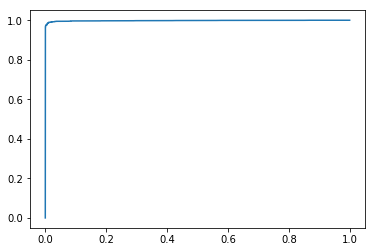

In [23]:
plt.plot(fpr,tpr);

In [24]:
auc(fpr,tpr)

0.9981372925424132

In [25]:
accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred)

(0.9856089224680697, 0.9963463646328097, 0.9749731855559528)

In [26]:
top_features = list(sorted(zip(x_train.columns, gr.best_estimator_.feature_importances_), key=lambda x: x[1], reverse=True))
top_features

[('AC', 0.06555667463213188),
 ('P48', 0.05658305388226826),
 ('TT', 0.050340771773990566),
 ('P38', 0.046469417067343755),
 ('TTT', 0.04561590289242951),
 ('CAC', 0.039909076594842864),
 ('ACT', 0.0360367050979811),
 ('P40', 0.03515122747021669),
 ('AGG', 0.03355508401869096),
 ('P49', 0.025769464854306246),
 ('GCA', 0.023808120985816014),
 ('CCT', 0.02287824141771057),
 ('TGC', 0.022530716632908274),
 ('GGA', 0.02243070571131373),
 ('GCT', 0.022390074150154607),
 ('CC', 0.021960138885648423),
 ('TTC', 0.02063233056558418),
 ('GTA', 0.01929512544148753),
 ('GG', 0.0140295160885116),
 ('TCA', 0.013816661358311147),
 ('GCG', 0.01363764916334954),
 ('AAC', 0.013583028728426049),
 ('TA', 0.013511998409121425),
 ('CTC', 0.011183142609222771),
 ('AA', 0.010175562126037334),
 ('GA', 0.009948143708361189),
 ('CG', 0.009861468300773514),
 ('AAA', 0.009089488309531326),
 ('P47', 0.008958350161348489),
 ('ACA', 0.008744749230936181),
 ('TC', 0.008166526072569685),
 ('CA', 0.007552704816990467),


In [27]:
len(gr.best_estimator_.feature_importances_)

130

In [28]:
len(x_train.columns)

130

In [29]:
gr.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [30]:
pd.DataFrame(
    columns=pairs, data=[
        x_all[y_all==1][pairs].mean(),
        x_all[y_all==0][pairs].mean(),
        x_all[y_all==1][pairs].std(),
        x_all[y_all==0][pairs].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(4)

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
Mean t,4.5616,4.5292,3.2199,2.5890,4.6038,3.5521,1.6346,4.1371,2.6512,3.2832,1.3362,2.5252,2.6204,2.7717,3.5383,1.4466
Mean f,4.7250,2.4508,3.4928,3.7937,3.5444,2.5809,0.4562,3.4500,2.9474,2.0614,2.5770,2.4555,3.2575,2.9377,3.5134,4.7561
Std t,4.4891,1.3275,1.7765,1.8319,1.2241,1.2633,1.5636,1.1999,1.9711,1.7236,1.2748,1.5517,2.7820,2.0357,1.3550,1.5844
Std f,3.3664,1.6410,2.0377,2.3188,1.8926,2.5041,0.9038,2.0273,1.9051,1.6225,2.5202,1.6656,2.3022,1.9178,1.8734,3.4192


In [31]:
pd.DataFrame(
    columns=triplets, data=[
        x_all[y_all==1][triplets].mean(),
        x_all[y_all==0][triplets].mean(),
        x_all[y_all==1][triplets].std(),
        x_all[y_all==0][triplets].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(1)

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
Mean t,2.1,1.3,0.7,0.5,1.5,0.9,0.2,1.9,1.6,0.9,...,0.2,0.8,0.3,1.4,0.6,1.2,0.4,0.2,0.4,0.2
Mean f,1.7,0.7,1.0,1.2,1.0,0.5,0.1,0.8,1.1,0.7,...,0.1,1.1,0.9,0.7,0.8,1.0,1.1,1.0,0.9,1.7
Std t,3.3,1.3,0.7,0.9,0.9,0.9,0.5,0.9,1.2,0.9,...,0.4,0.7,0.5,0.7,0.6,1.3,0.6,0.4,0.6,0.7
Std f,2.1,0.9,1.0,1.2,1.2,0.8,0.3,0.9,1.2,0.9,...,0.3,1.2,0.9,0.9,1.0,1.2,1.1,1.1,0.9,2.1


In [32]:
pd.DataFrame(
    columns=x_all.columns, data=[
        x_all[y_all==1].mean(),
        x_all[y_all==0].mean(),
        x_all[y_all==1].std(),
        x_all[y_all==0].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(2)[list(filter(bool, map(lambda x: x[0] in pairs+triplets and x[0] or None, top_features)))[:20]]

,AC,TT,TTT,CAC,ACT,AGG,GCA,CCT,TGC,GGA,GCT,CC,TTC,GTA,GG,TCA,GCG,AAC,TA,CTC
Mean t,4.53,1.45,0.20,1.77,1.91,0.10,1.51,1.31,1.39,0.11,0.08,3.55,0.18,0.91,1.34,0.23,0.73,1.30,2.62,1.51
Mean f,2.45,4.76,1.74,0.70,0.76,0.87,0.70,0.87,0.69,0.76,0.66,2.58,0.99,0.53,2.58,0.94,0.10,0.70,3.26,0.79
Std t,1.33,1.58,0.71,0.86,0.93,0.32,0.76,0.66,0.72,0.33,0.29,1.26,0.42,1.08,1.27,0.46,0.94,1.29,2.78,1.37
Std f,1.64,3.42,2.11,1.03,0.86,1.05,0.85,1.04,0.85,0.96,0.83,2.50,1.06,0.76,2.52,0.96,0.40,0.86,2.30,1.10
